# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

## Инструкция по выполнению проекта

 **1. Загрузите и подготовьте данные. Поясните порядок действий.**  
 **2. Обучите и проверьте модель для каждого региона:**      
    2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.  
    2.2. Обучите модель и сделайте предсказания на валидационной выборке.  
    2.3. Сохраните предсказания и правильные ответы на валидационной выборке.  
    2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.  
    2.5. Проанализируйте результаты.  
 **3. Подготовьтесь к расчёту прибыли:**        
    3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.    
    3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.  
    3.3. Напишите выводы по этапу подготовки расчёта прибыли.  
 **4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**    
    4.1. Выберите скважины с максимальными значениями предсказаний.  
    4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.  
    4.3. Рассчитайте прибыль для полученного объёма сырья.  
 **5. Посчитайте риски и прибыль для каждого региона:**    
    5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
    5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
    5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

#### Условия задачи:

 -  > Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
 -  >  При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
 -  >  Бюджет на разработку скважин в регионе — 10 млрд рублей.  
 -  >  При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
 -  >  После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Libs

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### 1. Загрузите и подготовьте данные. Поясните порядок действий.

In [2]:
geo_0 = pd.read_csv('geo_data_0.csv')
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_1 = pd.read_csv('geo_data_1.csv')
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
geo_2 = pd.read_csv('geo_data_2.csv')
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Посмотрим подробную информацию о каждом датасете

##### geo_0

In [5]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


###### Пропущенных значений нет.  Изменять типы не требуется.

In [7]:
geo_0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

##### geo_1

In [8]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


###### Пропущенных значений нет.  Изменять типы не требуется.

In [9]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
geo_1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

##### geo_2

In [11]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [13]:
geo_2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


###### Пропущенных значений нет.  Изменять типы не требуется.

##### Проверим наличие дублей.

In [14]:
print(geo_0.duplicated().sum())
print(geo_1.duplicated().sum())
print(geo_2.duplicated().sum())

0
0
0


<Figure size 864x576 with 0 Axes>

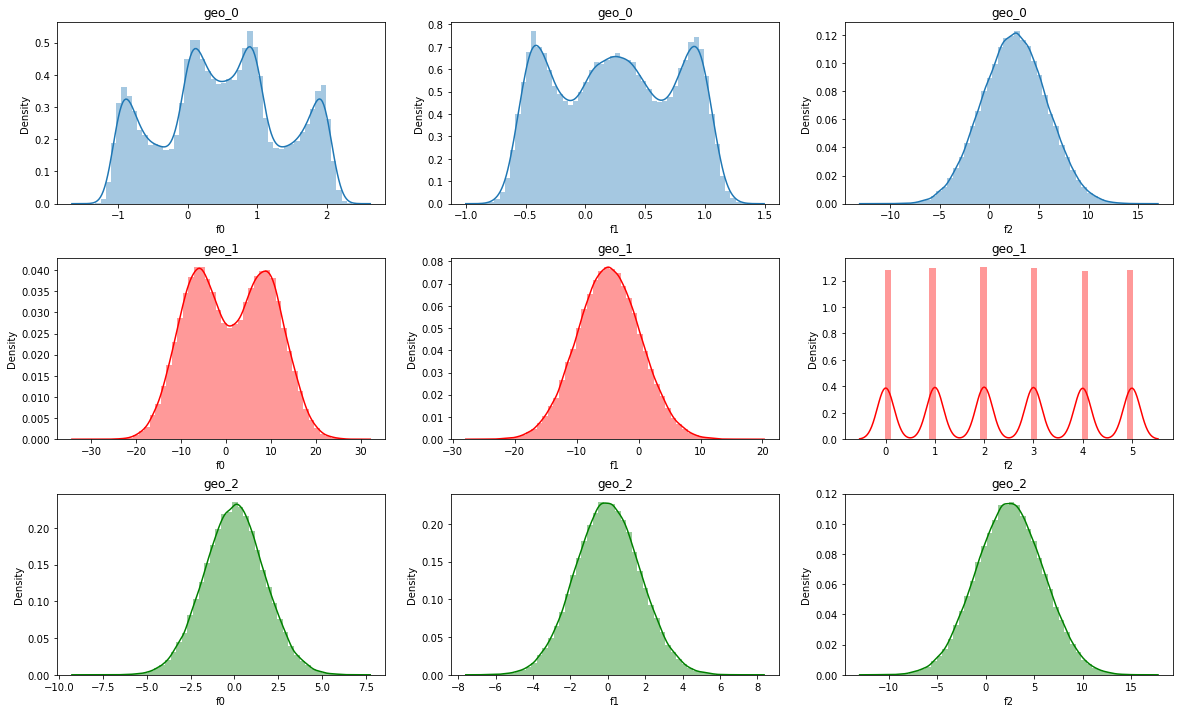

In [15]:
plt.figure(figsize=(12, 8))

fig, axes = plt.subplots(3, 3, figsize=(20,12))

sns.distplot(geo_0['f0'], ax = axes[0,0]).set_title('geo_0')
sns.distplot(geo_0['f1'], ax = axes[0,1]).set_title('geo_0')
sns.distplot(geo_0['f2'], ax = axes[0,2]).set_title('geo_0')

sns.distplot(geo_1['f0'], ax = axes[1,0], color = 'r').set_title('geo_1')
sns.distplot(geo_1['f1'], ax = axes[1,1], color = 'r').set_title('geo_1')
sns.distplot(geo_1['f2'], ax = axes[1,2], color = 'r').set_title('geo_1')

sns.distplot(geo_2['f0'], ax = axes[2,0], color = 'g').set_title('geo_2')
sns.distplot(geo_2['f1'], ax = axes[2,1], color = 'g').set_title('geo_2')
sns.distplot(geo_2['f2'], ax = axes[2,2], color = 'g').set_title('geo_2')

fig.subplots_adjust(hspace=.3)
plt.show()

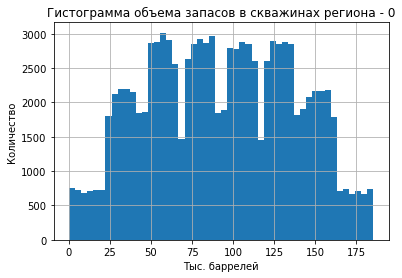

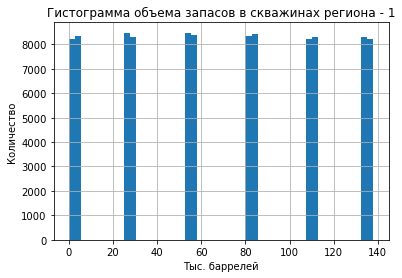

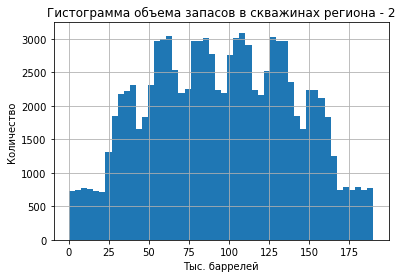

In [16]:
dataset_product = [geo_0['product'], geo_1['product'], geo_2['product']]

i = 0

for dataset in dataset_product:
    ax = dataset.hist(bins=50);
    ax.set_title("Гистограмма объема запасов в скважинах региона - {}".format(i))
    ax.set_xlabel("Тыс. баррелей")
    ax.set_ylabel("Количество")
    plt.show()
    i += 1

#### Построим матрицу корреляций для каждого датасета.

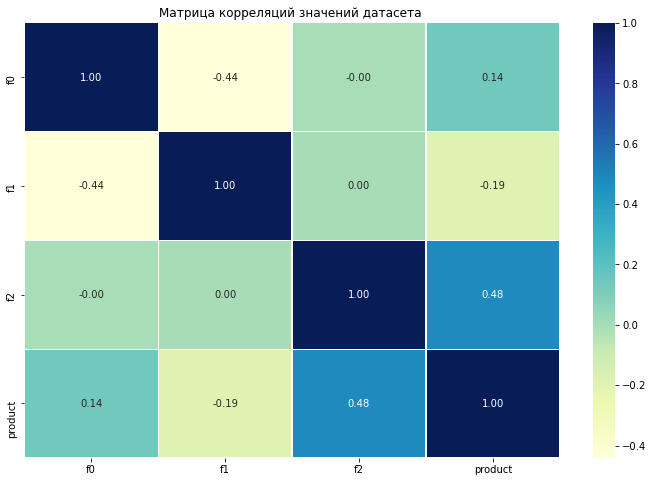

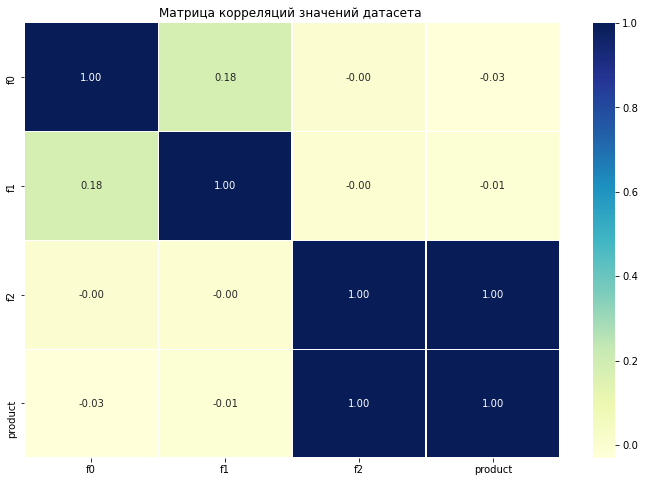

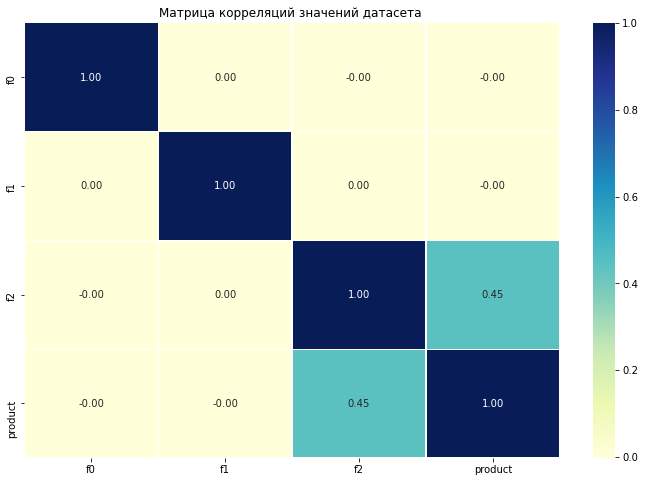

In [17]:
for dataset in geo_0, geo_1, geo_2:
    plt.figure(figsize=(12, 8))
    sns.heatmap(dataset.corr(), annot=True, linewidths=.1, fmt= '.2f', cmap="YlGnBu")
    plt.title(f'Матрица корреляций значений датасета ');

#### Признак f2 для региона 1 прямо коррелирует с признаком product. Уберем этот признак из датасета для упрощения обучения модели.

2. Обучите и проверьте модель для каждого региона:  
    2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.  
    2.2. Обучите модель и сделайте предсказания на валидационной выборке.  
    2.3. Сохраните предсказания и правильные ответы на валидационной выборке.  
    2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.  
    2.5. Проанализируйте результаты.  

##### Уберем колонку id, для построения модели она нам не нужна.

In [18]:
for data in geo_0, geo_1, geo_2:
    data.drop('id', axis=1, inplace=True)

#### Напишем функцию для построения модели

In [222]:
result = []

In [223]:
def train_model(data, print_shape=False):
    
    # Выделим признаки
    feature = data.drop('product', axis=1)
    target = data['product']
    
    # Разделим датасет на тренировочную и валидационную выборки
    feature_train, feature_valid, target_train, target_valid = train_test_split(
        feature, target, test_size=.25, random_state=2021)
    
    # Обучим модель
    lr = LinearRegression()
    lr.fit(feature_train, target_train)
    lr_predict = lr.predict(feature_valid)
    
    predict_mean = lr_predict.mean()
    valid_mean = target_valid.mean()
    rmse = mean_squared_error(target_valid, lr_predict) ** .5
    mse = mean_squared_error(target_valid, lr_predict)
    r2_train = lr.score(feature_train, target_train)
    r2_valid = r2_score(target_valid, lr_predict)
    result.append([rmse, mse, r2_train, r2_valid, predict_mean, valid_mean])
    
    print('=='*30)
    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('Cредний фактический запас сырья: {:.4f}'.format(valid_mean))
    print('RMSE модели: {:.4f}'.format(rmse))
    print('Cредняя квадратичная ошибка (MSE) модели: {:.4f}'.format(mse))
    print('Коэффициент детерминации (R2) модели по валидационным данным: {:.4f}'.format(r2_valid))
    print('Коэффициент детерминации (R2) модели по тренировочным данным: {:.4f}'.format(r2_train))
    
    if print_shape:
        print('=='*30)
        print('Размер тестовых данных', feature_train.shape[0], target_train.shape[0])
        print('Размер валидационных  данных', feature_valid.shape[0], target_valid.shape[0])
    
    return pd.DataFrame({'predicted_valid': lr_predict, 'target_valid': target_valid})                  

In [224]:
model_0 = train_model(geo_0)
model_1 = train_model(geo_1)
model_2 = train_model(geo_2)

Cредний запас предсказанного сырья: 92.6759
Cредний фактический запас сырья: 92.5915
RMSE модели: 37.5849
Cредняя квадратичная ошибка (MSE) модели: 1412.6244
Коэффициент детерминации (R2) модели по валидационным данным: 0.2742
Коэффициент детерминации (R2) модели по тренировочным данным: 0.2762
Cредний запас предсказанного сырья: 68.8387
Cредний фактический запас сырья: 68.8295
RMSE модели: 0.8903
Cредняя квадратичная ошибка (MSE) модели: 0.7927
Коэффициент детерминации (R2) модели по валидационным данным: 0.9996
Коэффициент детерминации (R2) модели по тренировочным данным: 0.9996
Cредний запас предсказанного сырья: 94.9891
Cредний фактический запас сырья: 94.8782
RMSE модели: 39.9954
Cредняя квадратичная ошибка (MSE) модели: 1599.6284
Коэффициент детерминации (R2) модели по валидационным данным: 0.2002
Коэффициент детерминации (R2) модели по тренировочным данным: 0.1983


#### Для оценки RMSE обычно сравнивают MSE предсказаний  со средним MSE по выборке. Существует коэффициент детерминации R2(1 - MSE/MSEсреднее). Показатель должен стремиться к 1. По региону 1 R2 =  0.9996, это связано с сильной корреляцией признака f2 c целевым признаком.


In [225]:
model_0

,predicted_valid,target_valid
23307,93.552642,72.571370
36679,113.987201,76.892871
36626,74.589530,63.330889
83753,80.953776,135.852043
52604,73.325089,113.007759
...,...,...
79256,113.005102,114.893755
41152,98.453068,101.375835
70974,83.957328,28.841471
61642,78.844874,62.703319


In [227]:
results = (
    pd.DataFrame(result, 
                 columns=['rmse', 'mse', 'r2_train', 'r2_valid', 'predict_mean', 'valid_mean'])
                .rename(index={0: 'geo_0', 1: 'geo_1', 2: 'geo_2'})
          )
display(results)

,rmse,mse,r2_train,r2_valid,predict_mean,valid_mean
geo_0,37.584896,1412.624439,0.276203,0.274169,92.675936,92.591548
geo_1,0.890342,0.792708,0.999623,0.999627,68.838718,68.829462
geo_2,39.995355,1599.628440,0.198342,0.200185,94.989112,94.878239


## Вывод:
  - Самый низкий показатель по метрике rmse (Корень из средней квадратичной ошибки) приходится на 1-модель (об улучшении качества свидетельствует снижение метрики), коэффициент детерминации также самый высокий из всех моделей. Предсказанные и истинные значения практически одинаковы. Это означает, что модель хорошо предсказыванет целевой признак, но объем самый низкий из всех регионов 68 тыс.баррелей. Рекомендовать этот регион рискованно по причине того, что в нем всего 12 уникальных значений из 100 000 целевого признака. Возможно из-за этого модель легко прогнозировала данные. 

### 3. Подготовьтесь к расчёту прибыли:
3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.  
3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.  
3.3. Напишите выводы по этапу подготовки расчёта прибыли.  

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [228]:
n_wells = 500
best_n_wells = 200
costs = 10_000_000_000
profit_per_barrel = 450_000
alpha = .95
theshold_risk = .025

In [229]:
break_even_point = costs / (profit_per_barrel * best_n_wells)
print('Минимальный объём сырья для разработки новой скважины: {:.2f} тыс. баррелей'.format(break_even_point))

Минимальный объём сырья для разработки новой скважины: 111.11 тыс. баррелей


### Вывод: Ни один из регионов не подходит под заданные условия. Во всех регионах прогнозируемый  объем ниже минимально возможного + 2,5%.

#### 4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 4.1. Выберите скважины с максимальными значениями предсказаний.  
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.  
 4.3. Рассчитайте прибыль для полученного объёма сырья.  

### Функция расчёта прибыли по истинным значениям для выбранных скважин, на основании предсказанных значений

In [232]:
def calculate_profit(data, print_results=True):
    
    # Получим лучшие скважины на основе предсказаний и реальные значения объемов запасов для лучших скважин
    target_top = (
                    data
                    .sort_values('predicted_valid', ascending=False)
                    .iloc[:best_n_wells, 1]
                 )
    
    # Общий запас сырья по лучшим скважинам
    top_sum = target_top.sum()
    # Средний запас сырья по лучшим скважинам
    top_mean = target_top.mean()
    # Посчитаем прибыль и переведем в млрд.руб.
    profit = (top_sum * profit_per_barrel - costs) / 10 ** 9
    
    if print_results:
        print('Средний запас сырья среди скважин с максимальными объемами: {:.3f} тыс. баррелей'.format(top_mean))
        print('Суммарный целевой объем сырья: {:.3f} тыс. баррелей'.format(top_sum))
        print('Прибыль для 200 лучших скважин: {:.3f} млрд. руб'.format(profit))
    
    return profit

In [233]:
print('Регион 0:')
calculate_profit(model_0, print_results=True)
print('Регион 1:')
calculate_profit(model_1, print_results=True)
print('Регион 2:')
calculate_profit(model_2, print_results=True)

Регион 0:
Средний запас сырья среди скважин с максимальными объемами: 145.968 тыс. баррелей
Суммарный целевой объем сырья: 29193.529 тыс. баррелей
Прибыль для 200 лучших скважин: 3.137 млрд. руб
Регион 1:
Средний запас сырья среди скважин с максимальными объемами: 137.945 тыс. баррелей
Суммарный целевой объем сырья: 27589.082 тыс. баррелей
Прибыль для 200 лучших скважин: 2.415 млрд. руб
Регион 2:
Средний запас сырья среди скважин с максимальными объемами: 139.804 тыс. баррелей
Суммарный целевой объем сырья: 27960.733 тыс. баррелей
Прибыль для 200 лучших скважин: 2.582 млрд. руб


2.582329798544878

In [288]:
random_state = np.random.RandomState(2021)
bootstrap_samples = 1000
pivot_table_on_region = []

#### Функция бутстрепа

In [289]:
def profit_bootstrap(data):
    # Создаем list для хранения прибыли
    values = []
    for i in range(bootstrap_samples):
        # Берем 500 скважин из региона
        subsample = data.sample(n=n_wells, replace=True,
                                random_state=random_state)
        # Получим истинные значения для выбранных скважин и значения прибыли из предыдущей функции. Добавим в list values
        values.append(calculate_profit(subsample, False))

    values = pd.Series(values)
    values_mean = values.mean()

    # Рассчитаем 95% доверительный интервал
#     confidence_interval = st.t.interval(alpha=alpha, 
#                                         df=len(values) - 1, 
#                                         loc = values.mean(), 
#                                         scale = values.sem())
    confidence_interval = .05
    interval_lower = values.quantile(confidence_interval / 2)
    interval_upper = values.quantile(1 - confidence_interval / 2)
    
    # Рассчитаем вероятность убытка
    loss_ratio = (values < 0).mean()
    pivot_table_on_region.append([values_mean, interval_lower, interval_upper, loss_ratio * 100])
    
    print('Средняя прибыль = {:.3f} млрд. руб.'.format(values_mean))
    print('Доверительный интервал 95% = [{:.3f}, {:.3f}]'.format(interval_lower, interval_upper))
    print('Вероятность убытка  {:.1%}'.format(loss_ratio))

    return values

In [290]:
print('Регион 0:')
income_region_0 = profit_bootstrap(model_0)
print('--'*30)
print('Регион 1:')
income_region_1 = profit_bootstrap(model_1)
print('--'*30)
print('Регион 2:')
income_region_2 = profit_bootstrap(model_2)

Регион 0:
Средняя прибыль = 0.420 млрд. руб.
Доверительный интервал 95% = [-0.105, 0.918]
Вероятность убытка  5.6%
------------------------------------------------------------
Регион 1:
Средняя прибыль = 0.462 млрд. руб.
Доверительный интервал 95% = [0.070, 0.888]
Вероятность убытка  0.9%
------------------------------------------------------------
Регион 2:
Средняя прибыль = 0.341 млрд. руб.
Доверительный интервал 95% = [-0.203, 0.899]
Вероятность убытка  10.7%


In [291]:
pivot_table_on_region = pd.DataFrame(data=pivot_table_on_region, 
                         columns=['Средняя прибыль, млрд.руб', 
                                  'Доверительный интервал нижний, млрд.руб', 
                                  'Доверительный интервал верхний, млрд.руб', 
                                  'Вероятность убытка, %'], 
                         index=['region_0', 'region_1', 'region_2'])
pivot_table_on_region

,"Средняя прибыль, млрд.руб","Доверительный интервал нижний, млрд.руб","Доверительный интервал верхний, млрд.руб","Вероятность убытка, %"
region_0,0.420212,-0.105379,0.917593,5.6
region_1,0.462127,0.069559,0.888081,0.9
region_2,0.341055,-0.202613,0.899284,10.7


5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

### Вывод:
    
 -  Регионы 0 и 2 показывают более высокие значения по запасам сырья, чем регион 1. В то же время метрика RMSE у них намного выше. Это говорит о низком качестве предсказаний для данных регионов.
 -    Регион 1 имеет значение 0,89 по метрике RMSE(чем ближе значение к 0, тем лучше модель предсказывет данные).
 -    Средняя прибыль по региону 1 самыя высокая из представленных - 460 млн. рублей (0.462127 млрд.руб).
 -    Средние запасы на 200 лучших скважинах превышают минимальный порог в 111 тыс.барелей.
 -    Вероятность убытка по региону 1 самая низкая ~ 1%. При этом минимальная прибыль будет ~ 70 млн.руб(69559 млн.руб)  
**На основании вышеизложенного считаем, что оптимальным регионом для разработки будет регион 1.**